# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

# Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

# Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

# Importar Librerias y Leer los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb

In [2]:
#Cargar el dataframe y utilizar la primera columna como índice y parsear las fechas.
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Preparación

In [3]:
# Revisar el df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Ordenar el Data Frame por el Indice
df.sort_index(inplace=True)

# Remuestrear los datos por hora para reagruparlos y sumarlos
df = df.resample('1H').sum()

**OBSERVACIONES:** Revisamos nuestro conjunto de datos y lo cargamos de tal forma que nuestra serie contenga como indice los horarios  y hacemos un parseo de las fechas para poder trabajar con los datos y por ultimo remuestreamos los datos por hora.

## Análisis

graficas desvucon movil , media movil, descomposciion estacional

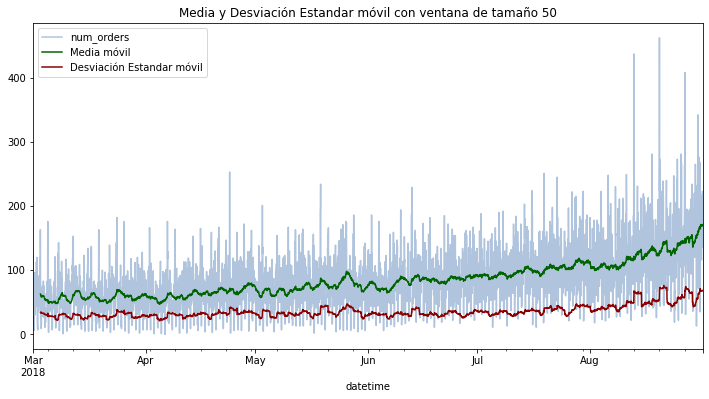

In [5]:
# Grafico de media movil con un tamaño de ventana(50)
df['rolling_mean'] = df.rolling(50).mean()
df['rolling_std'] = df['num_orders'].rolling(50).std()

# Ajustar el color de fondo a un tono de azul grisáceo
ax = df['num_orders'].plot(figsize=(12, 6), color='lightsteelblue')  

# Agregar las líneas de la media móvil y la desviación móvil con colores específicos
df['rolling_mean'].plot(ax=ax, color='darkgreen', label='Media móvil')
df['rolling_std'].plot(ax=ax, color='darkred', label='Desviación Estandar móvil')

# Agregar el titulo al grafico
plt.title('Media y Desviación Estandar móvil con ventana de tamaño 50')

# Añadir leyendas con colores específicos
ax.legend(loc='upper left')

plt.show()

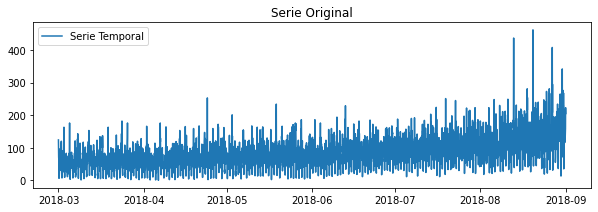

In [16]:
# Realiza la descomposición estacional
result = seasonal_decompose(df['num_orders'], model='additive')

# Grafica la descomposición
plt.figure(figsize=(10, 14))

# Serie original
plt.subplot(4, 1, 1)
plt.plot(df['num_orders'], label='Serie Temporal')
plt.title('Serie Original')
plt.legend()


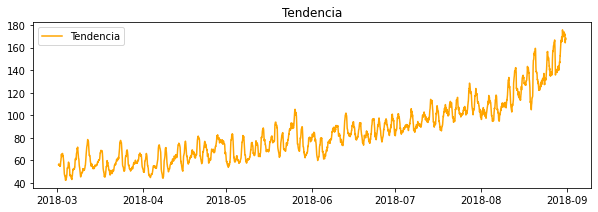

In [17]:
# Tendencia
plt.figure(figsize=(10, 14))
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia', color='orange')
plt.title('Tendencia')
plt.legend()

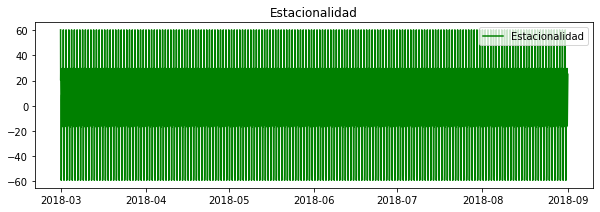

In [18]:
# Estacionalidad
plt.figure(figsize=(10, 14))
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.legend()

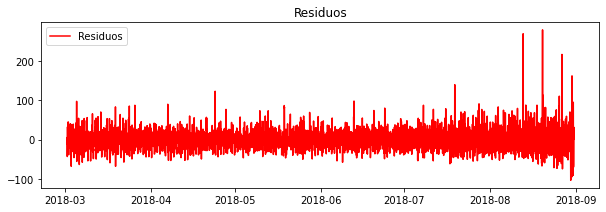

In [19]:
# Residuos
plt.figure(figsize=(10, 14))
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos', color='red')
plt.title('Residuos')
plt.legend()


**OBSERVACIONES:** La desviacion estandar en nuestro conjunto de datos es menor que nuestra media lo cual es bueno por que no tenemos mucha variacion. En el primer grafico de color azul que representa nuestra serie original podemos ver que el valor medio no cambia mucho con el tiempo y tambien en el grafico verde podemos ver que es estacional. Podemos ver que dependiendo de la estación existe un patron de aumento, es decir que a medida que aumentamos la fecha aumentan la cantidad de taxis pedidos. 

## Formación

In [21]:
df.drop(columns=['rolling_mean', 'rolling_std'], inplace=True)
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())
    
make_features(df, 50, 2)
print(df.head(5))

                     num_orders  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
datetime                                                                    
2018-03-01 00:00:00         124    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85  124.0    NaN    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00          71   85.0  124.0    NaN    NaN    NaN    NaN   
2018-03-01 03:00:00          66   71.0   85.0  124.0    NaN    NaN    NaN   
2018-03-01 04:00:00          43   66.0   71.0   85.0  124.0    NaN    NaN   

                     lag_7  lag_8  lag_9  ...  lag_42  lag_43  lag_44  lag_45  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...     NaN  

In [22]:

# Dividiremos los datos como se nos pidio 90 para entrenar y 
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

**OBSERVACIONES:** Creamos las caracteristicas con una lag de 50 y una ventana para la media de 2. Ademas dividimos los datos como se nos pidio al darle al conjunto de entrenamiento un 90 porciento y al conjundo de prueba un 10 porciento del dataset original.

## Prueba

In [23]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("EAM para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train))
print("EAM para el conjunto de prueba:", mean_squared_error(target_test, pred_test))

EAM para el conjunto de entrenamiento: 549.1685708282774
EAM para el conjunto de prueba: 1754.153844295758


In [25]:
# Crear el modelo Random Forest
# Definir los hiperparámetros de los que deseamos buscar los mejores
param_grid = {
    'n_estimators': [40, 80, 120],
    'max_depth': [4, 8, 12],
}

# Crear el modelo Random Forest
model_rf = RandomForestRegressor()

# Configurar la búsqueda de cuadrícula
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')

# Realizar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(features_train, target_train)

# Obtener los mejores parámetros encontrados por la búsqueda de cuadrícula
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Crear un nuevo modelo Random Forest con los mejores parámetros
best_model_rf = RandomForestRegressor(**best_params)

# Entrenar el modelo con los mejores parámetros
best_model_rf.fit(features_train, target_train)

# Predecir en los conjuntos de entrenamiento y prueba
pred_train_rf = best_model_rf.predict(features_train)
pred_test_rf = best_model_rf.predict(features_test)

# Calcular RMSE para Random Forest con los mejores parámetros
rmse_train_rf = np.sqrt(mean_squared_error(target_train, pred_train_rf))
rmse_test_rf = np.sqrt(mean_squared_error(target_test, pred_test_rf))

print("RMSE para Random Forest (entrenamiento) con los mejores parámetros:", rmse_train_rf)
print("RMSE para Random Forest (prueba) con los mejores parámetros:", rmse_test_rf)

Mejores parámetros encontrados: {'max_depth': 12, 'n_estimators': 120}
RMSE para Random Forest (entrenamiento) con los mejores parámetros: 10.825969477314962
RMSE para Random Forest (prueba) con los mejores parámetros: 43.01540222929704


In [24]:
# Crear el modelo LightGBM con parámetros ligeros
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': -1
}

model_lgb = lgb.LGBMRegressor(**params)

# Entrenar el modelo
model_lgb.fit(features_train, target_train)

# Predecir en los conjuntos de entrenamiento y prueba
pred_train_lgb = model_lgb.predict(features_train)
pred_test_lgb = model_lgb.predict(features_test)

# Calcular RMSE para LightGBM
rmse_train_lgb = np.sqrt(mean_squared_error(target_train, pred_train_lgb))
rmse_test_lgb = np.sqrt(mean_squared_error(target_test, pred_test_lgb))

print("RMSE para LightGBM (entrenamiento):", rmse_train_lgb)
print("RMSE para LightGBM (prueba):", rmse_test_lgb)

RMSE para LightGBM (entrenamiento): 10.945943069193348
RMSE para LightGBM (prueba): 41.273495100473205


In [26]:
# Crear el modelo XGBoost con parámetros ligeros
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'verbosity': 0
}

model_xgb = xgb.XGBRegressor(**params)

# Entrenar el modelo
model_xgb.fit(features_train, target_train)

# Predecir en los conjuntos de entrenamiento y prueba
pred_train_xgb = model_xgb.predict(features_train)
pred_test_xgb = model_xgb.predict(features_test)

# Calcular RMSE para XGBoost
rmse_train_xgb = np.sqrt(mean_squared_error(target_train, pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(target_test, pred_test_xgb))

print("RMSE para XGBoost (entrenamiento):", rmse_train_xgb)
print("RMSE para XGBoost (prueba):", rmse_test_xgb)

RMSE para XGBoost (entrenamiento): 19.168274007488662
RMSE para XGBoost (prueba): 41.599883008756045


# Tabla con los resultados

In [27]:
resultados =  {
    'Modelo': ['RandomForestRegressor','LightGBM','XGBoost','LinearRegression'],
    'RMSE (Entrenamiento)': [10.83, 10.95, 19.17, 549.17],  # RMSE obtenido en prueba para cada modelo
    'RMSE (Prueba)': [43.02, 41.27, 41.60, 1754.15]  
}
# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla
display(df_resultados)

,Modelo,RMSE (Entrenamiento),RMSE (Prueba)
0,RandomForestRegressor,10.83,43.02
1,LightGBM,10.95,41.27
2,XGBoost,19.17,41.60
3,LinearRegression,549.17,1754.15


**OBSERVACIONES:** Podemos ver que Nuestro modelo que mejor predice con el conjunto de prueba es el `RandomForestRegressor`por muy poco pero para el onjunto de entrenamiento nuestro mejor modelo es el `LightGBM` por lo cual en esta ocasion obtaremos por tomar como mejor modelo al modelo `LightGBM`.

# Conlusion

De este proyecto me gustaria destacar 3 puntos principales.

1. Nuestro mejor modelo para esta ocasion es `LightGBM` con un RMSE de error en el conjunto de prueba de 41.27 siendo mejor al limite de 48 que se nos pedia.
2. Debemos decidir bien nuestros parametros para la cantidad de lag que aplicaremos respecto a la cantidad de datos que tenemos para no perder mucha información.
3. Nuestra desviación estandar movil era inferior a nuestra media movil  lo cual sugiere que los datos están menos dispersos alrededor de la tendencia central.
